In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Key doubts before proceeding to the project:

1. Duplicate rows
2. Using SQL in place of csv file (especially in cases where null/empty values/duplicate rows are to be found)
3. Strategy when there are a lot of categorical variables
4. Suppose a column has almost 0 correlation with the target variable (Churn in this case). Can it be directly removed or should we keep it in case of it having a very high correlation when combined with another column ?
5. How to ensure GPU is being used?
6. Change scale of X-axis for tenure on X?

## FINDING THE DUPLICATES

NOTE: Find some easy way to print/ see them somewhere
There are many customers with duplicate attributes and some are churning, and some are not. Monthly_Charges and Total_Charges have been not included because the duplicate rows have only minute differences in these columns

In [ ]:
cols = df.columns.tolist()
cols.remove('customerID')
cols.remove('Total_Charges')
cols.remove('Monthly_Charges')
duplicates = df[df.duplicated(cols, keep= False)]
duplicates

In [8]:
duplicates.to_csv(path + '/Datasets/duplicates.csv', index=False)

**IMPORTING THE DATASET**

In [2]:
path = 'D:/work/pythonPractice/big projects/Blitzkrieg'
df = pd.read_csv(path + '/Original/Case Data.csv')
df.shape

(7044, 21)

In [ ]:
df.head(10)

### Checking the data types

In [ ]:
df.info()

Here, **Monthly_Charges** and **Total_Charges** both should be float64 types, but the latter is not. This means it probably contains some strings (most probably empty).

In [ ]:
# shit for replacing empty strings in TC
print('Not number values:',pd.isna(df['Total_Charges']).value_counts())
print('Null values:',np.where(pd.isnull(df)))
print('Space strings:', [x for x in df['Total_Charges'] if x == ' '])
print(df.isna().sum())

In [ ]:
df['Total_Charges'].replace(" ", 0.0,inplace=True)
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.info()

The **customerID** column will be unique for each row/customer and thus has no relation to churnability. So, the column will be deleted.

In [14]:
# df = df.iloc[:,1:]
# df = df.drop(columns =['customerID'])
del df['customerID']
df.head()

,gender,Senior_Citizen,Partner,Dependents,tenure,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## HYPOTHESES  &  OBSERVATIONS:

The most important variables for churning can be the following:
1. Tenure
2. Monthly charges
3. Type of plan (Combo of phone and internet services chosen by the customer)
4. Contract Type (of one subscription)

**This dataset is for postpaid customers and there have to be some fixed number of plans. These plans would have a fixed cost + usage dependent variable costs.**

The plans can be found based on the graphs, however usage column is a bit tricky.


### HYTHOSESIS-1: FIXED NUMBER OF PLANS 

Plotting the 3rd and 4th variables on plots of the first 2 churn important variables: 

In [16]:
# ct = pd.DataFrame([df.tenure[x] for x in range(7043) if int(df['Churn'][x])==1],columns = ['Churns'])
# ct['Churns'].value_counts().head(73).plot(kind='bar',figsize=(20,10))
# Use group by function of pandas and group for tenures by 3 months

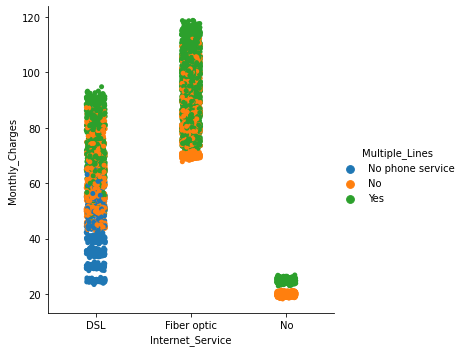

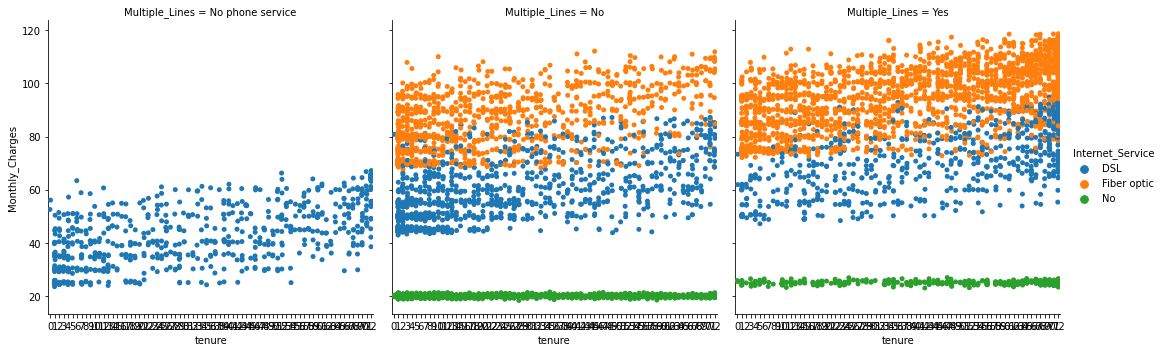

In [17]:
sns.catplot(x = 'Internet_Service', y = 'Monthly_Charges',hue='Multiple_Lines', data=df)
sns.catplot(x = 'tenure', y = 'Monthly_Charges', col= 'Multiple_Lines', hue='Internet_Service', data=df)

**OBSERVATIONS:**

1. As can be seen, the lowest monthly charges are those for no Internet Services + 1 phone connection. This is the 1st plan: **NoNet-1**
2. The next lowest monthly charges are those for:
    i. DSL + No Phone connection (2nd plan: **DSL-0**)
    ii. no Internet Services + Multiple phone connections (3rd plan: **NoNet-1**)
3. Fiber Optics customers are required to have at least 1 phone connections. (See the left most graph in the 2nd plot) Thus, there are 2 possible plans for FO customers:
    i. FO + 1 phone connection **(FO-1)**
    ii. FO + Multiple phone connections **(FO-2)**
4. DSL customers have 3 options based on the number of phone connections: **DSL-0, DSL-1** (1), **DSL-2** (1+) 
5. DSL-0 and DSL-1, and, FO-1 and FO-2 can have the same cost. This depends on the number of features the user subscribes for. (Proved in later illustrations)

**Merging Internet Service Columns with Phone Lines columns to create a Plan column**

In [15]:
# Replacing text values with ints in Multiple_Lines column
df['Multiple_Lines'].replace("No", 1,inplace=True)
df['Multiple_Lines'].replace("Yes", 2,inplace=True)
df['Multiple_Lines'].replace("No phone service", 0,inplace=True)

# rename column to No.of phone lines
df.rename(columns = {'Multiple_Lines':'Phone_Lines_No'}, inplace = True)

# Deleting redundant Phone_service column
del df['Phone_Service']

Now, the ***Phone_Lines_No column*** describes how many phone connections does a customer have. 
<ul><li>0 : No phone connections</li><li>1: A single phone connection</li><li>2: Multiple phone connections</li></ul>

The following code is not used because it does not work in a loop and thus, is not selected for execution. However, as changes are done directly to the columns (instead of creating a new array like in the 2nd method), this method seems safer (but mentioning again, not used here). 

In [11]:
# p1_inp = [1 if df['Phone_Lines_No'][x] == 0 and df['Internet_Service'][x] == 'DSL' else 0 for x in range(7044)]
# df.insert(5,'DSL-0',p1_inp)
# p2_inp = [1 if df['Phone_Lines_No'][x] == 1 and df['Internet_Service'][x] == 'DSL' else 0 for x in range(7044)]
# df.insert(6,'DSL-1',p2_inp)
# p3_inp = [1 if df['Phone_Lines_No'][x] == 1 and df['Internet_Service'][x] == 'No' else 0 for x in range(7044)]
# df.insert(7,'NoNet-1',p3_inp)
# p4_inp = [1 if df['Phone_Lines_No'][x] == 2 and df['Internet_Service'][x] == 'No' else 0 for x in range(7044)]
# df.insert(8,'NoNet-2',p4_inp)
# p5_inp = [1 if df['Phone_Lines_No'][x] == 1 and df['Internet_Service'][x] == 'Fiber optic' else 0 for x in range(7044)]
# df.insert(9,'FO-1',p5_inp)
# p6_inp = [1 if df['Phone_Lines_No'][x] == 2 and df['Internet_Service'][x] == 'Fiber optic' else 0 for x in range(7044)]
# df.insert(10,'FO-2',p6_inp)
# print(p5_inp.count(1) + p6_inp.count(1))
# del df['Internet_Service']
# del df['Phone_Lines_No']

In [16]:
plan = []
for x in range(7044):
    if df['Phone_Lines_No'][x] == 1 and df['Internet_Service'][x] == 'No':
        plan.append('NoNet-1')
    elif df['Phone_Lines_No'][x] == 2 and df['Internet_Service'][x] == 'No':
        plan.append('NoNet-2')
    elif df['Phone_Lines_No'][x] == 0 and df['Internet_Service'][x] == 'DSL':
        plan.append('DSL-0')
    elif df['Phone_Lines_No'][x] == 1 and df['Internet_Service'][x] == 'DSL':
        plan.append('DSL-1')
    elif df['Phone_Lines_No'][x] == 2 and df['Internet_Service'][x] == 'DSL':
        plan.append('DSL-2')
    elif df['Phone_Lines_No'][x] == 1 and df['Internet_Service'][x] == 'Fiber optic':
        plan.append('FO-1')
    else:
        plan.append('FO-2')
df.insert(6,'Plan',plan)
df.head()

,gender,Senior_Citizen,Partner,Dependents,tenure,Phone_Lines_No,Plan,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,Female,No,Yes,No,1,0,DSL-0,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,1,DSL-1,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,1,DSL-1,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,0,DSL-0,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,1,FO-1,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [17]:
del df['Phone_Lines_No']
del df['Internet_Service']

In case of the six Internet Features variables column, two values (No, No Internet Service) can and have been clubbed together. 

In [18]:
df['Online_Security'].replace("No internet service", "No",inplace=True)
df['Online_Backup'].replace("No internet service", "No",inplace=True)
df['Device_Protection'].replace("No internet service", "No",inplace=True)
df['Tech_Support'].replace("No internet service", "No",inplace=True)
df['Streaming_TV'].replace("No internet service", "No",inplace=True)
df['Streaming_Movies'].replace("No internet service", "No",inplace=True)

### Encoding text columns

**Gender column**

My biggest yet the <u>silliest doubt</u>. ***By giving value=1 for Female customers, will the model not get biased towards female customers? Shouldn't the values be -0.5 and 0.5 so that mean remains 0?***

In [19]:
df['gender'].replace("Male", 0,inplace=True)
df['gender'].replace("Female", 1,inplace=True)
print(df['gender'].value_counts())

0    3555
1    3489
Name: gender, dtype: int64


In [20]:
df['Senior_Citizen'].replace("No", 0,inplace=True)
df['Senior_Citizen'].replace("Yes", 1,inplace=True)
print(df['Senior_Citizen'].value_counts())

df['Partner'].replace("No", 0,inplace=True)
df['Partner'].replace("Yes", 1,inplace=True)
print(df.Partner.value_counts())
# Like JS, obj.key works in pandas

df['Dependents'].replace("No", 0,inplace=True)
df['Dependents'].replace("Yes", 1,inplace=True)
print(df['Dependents'].value_counts())

df['Paperless_Billing'].replace("No", 0,inplace=True)
df['Paperless_Billing'].replace("Yes", 1,inplace=True)
print(df.Paperless_Billing.value_counts())

df['Churn'].replace("No", 0,inplace=True)
df['Churn'].replace("Yes", 1,inplace=True)
print(df.Churn.value_counts())

0    5902
1    1142
Name: Senior_Citizen, dtype: int64
0    3641
1    3403
Name: Partner, dtype: int64
0    4933
1    2111
Name: Dependents, dtype: int64
1    4172
0    2872
Name: Paperless_Billing, dtype: int64
0    5175
1    1869
Name: Churn, dtype: int64


*Add inputs based on distribution.*

In [21]:
df['Online_Security'].replace("No", 0,inplace=True)
df['Online_Security'].replace("Yes", 1,inplace=True)

df['Online_Backup'].replace("No", 0,inplace=True)
df['Online_Backup'].replace("Yes", 1,inplace=True)

df['Device_Protection'].replace("No", 0,inplace=True)
df['Device_Protection'].replace("Yes", 1,inplace=True)

df['Tech_Support'].replace("No", 0,inplace=True)
df['Tech_Support'].replace("Yes", 1,inplace=True)

df['Streaming_TV'].replace("No", 0,inplace=True)
df['Streaming_TV'].replace("Yes", 1,inplace=True)

df['Streaming_Movies'].replace("No", 0,inplace=True)
df['Streaming_Movies'].replace("Yes", 1,inplace=True)

### Ordinal columns

In [22]:
df['Contract'].replace("Month-to-month", 0,inplace=True)
df['Contract'].replace("One year", 1,inplace=True)
df['Contract'].replace("Two year", 2,inplace=True)
print(df.Contract.value_counts())

0    3875
2    1695
1    1474
Name: Contract, dtype: int64


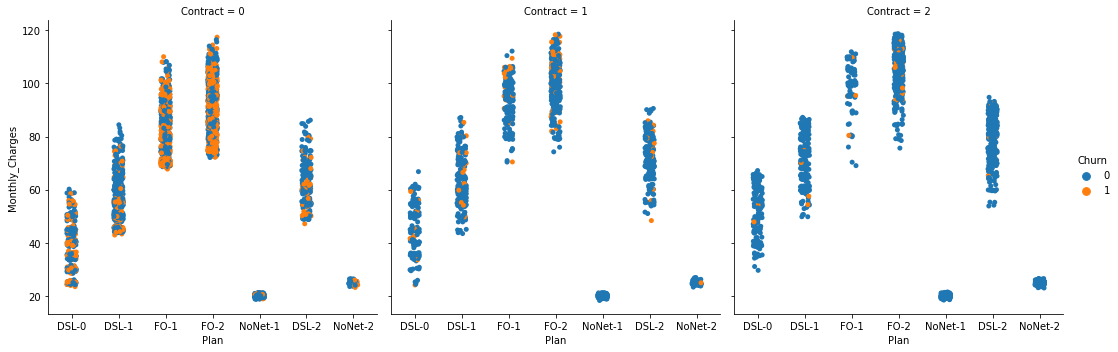

In [15]:
# increase size
sns.catplot(x = 'Plan', y = 'Monthly_Charges', col= 'Contract', hue='Churn', data=df)

**Find avg monthly charges and churn rate for each plan and contract type**

**OBSERVATIONS:**

The current plans benefit the longer contract users (obviously). However, people with long tenures have been churning out in all 3 contract types. This nature is more prevelant for shorter contracts because they can easily leave.

## Creating a seperate DF for tree based algorithms

In [23]:
tdf = df.copy()
tdf.head()

,gender,Senior_Citizen,Partner,Dependents,tenure,Plan,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,1,0,1,0,1,DSL-0,0,1,0,0,0,0,0,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,DSL-1,1,0,1,0,0,0,1,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,DSL-1,1,1,0,0,0,0,0,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,DSL-0,1,0,1,1,0,0,1,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,FO-1,0,0,0,0,0,0,0,1,Electronic check,70.70,151.65,1


### LabelEncoding for cardinal columns

In [24]:
tdf['Payment_Method'].replace("Electronic check", 0,inplace=True)
tdf['Payment_Method'].replace("Mailed check", 1,inplace=True)
tdf['Payment_Method'].replace("Bank transfer (automatic)", 2,inplace=True)
tdf['Payment_Method'].replace("Credit card (automatic)", 2,inplace=True)

tdf['Plan'].replace("NoNet-1", 0,inplace=True)
tdf['Plan'].replace("NoNet-2", 1,inplace=True)
tdf['Plan'].replace("DSL-0", 2,inplace=True)
tdf['Plan'].replace("DSL-1", 3,inplace=True)
tdf['Plan'].replace("DSL-2", 4,inplace=True)
tdf['Plan'].replace("FO-1", 5,inplace=True)
tdf['Plan'].replace("FO-2", 6,inplace=True)

In [26]:
tdf.to_csv(path + '/Datasets/Tree_case_data.csv', index = False)
tdf.head()

,gender,Senior_Citizen,Partner,Dependents,tenure,Plan,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,1,0,1,0,1,2,0,1,0,0,0,0,0,1,0,29.85,29.85,0
1,0,0,0,0,34,3,1,0,1,0,0,0,1,0,1,56.95,1889.50,0
2,0,0,0,0,2,3,1,1,0,0,0,0,0,1,1,53.85,108.15,1
3,0,0,0,0,45,2,1,0,1,1,0,0,1,0,2,42.30,1840.75,0
4,1,0,0,0,2,5,0,0,0,0,0,0,0,1,0,70.70,151.65,1


## Formatting of columns for distance and GD-based algorithms

### OneHotEncoding for cardinal columns

In [27]:
print(df['Payment_Method'].value_counts(),'\n')
print(df['Plan'].value_counts())

df.to_csv(path + '/Datasets/dis_GD_case_study.csv')
df = pd.get_dummies(df,columns = ['Payment_Method','Plan'], prefix= '', prefix_sep = '', drop_first = True)
df.info()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1523
Name: Payment_Method, dtype: int64 

FO-2       1939
NoNet-1    1184
FO-1       1158
DSL-1      1048
DSL-2       691
DSL-0       682
NoNet-2     342
Name: Plan, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7044 entries, 0 to 7043
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   7044 non-null   int64  
 1   Senior_Citizen           7044 non-null   int64  
 2   Partner                  7044 non-null   int64  
 3   Dependents               7044 non-null   int64  
 4   tenure                   7044 non-null   int64  
 5   Online_Security          7044 non-null   int64  
 6   Online_Backup            7044 non-null   int64  
 7   Device_Protection        7044 non-null   int64  
 8   Tech_Support             7044 non-null

### HYPOTHESIS-2: Usage variable

Monthly charges will mostly depend upon:
1. Type of plan (Combo of phone and internet services chosen by the customer)
2. Number of features subscribed by the user
3. Contract Type (same plan and number of features can have different monthly charges for different contracts?)

The values are quite skewed in nature. ***What is the significance of skewness and kurtosis of a continuous variable to the final model? Is there a need to convert such data distributions into a normal/Gaussian type?***

Skewness: -0.22071962421798602, Kurtosis: -1.257282278445048


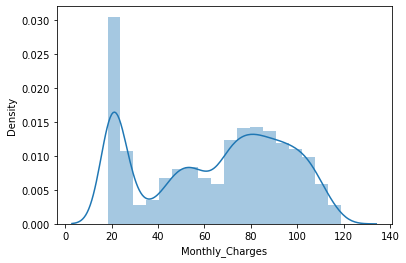

In [11]:
sns.distplot(df['Monthly_Charges'])
print(f'Skewness: {df.Monthly_Charges.skew()}, Kurtosis: {df.Monthly_Charges.kurt()}')

In [ ]:
sns.distplot(df['Total_Charges'])
print(df.Total_Charges.skew(), df.Total_Charges.kurt())

In [ ]:
sns.distplot(df['tenure'])
print(df.tenure.skew(), df.tenure.kurt())

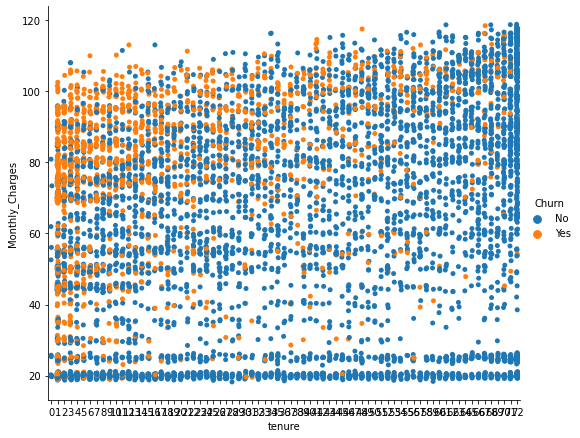

In [7]:
sns.catplot(x = 'tenure', y = 'Monthly_Charges',hue = 'Churn', data=df, height = 6,aspect =1.4)

In [ ]:
sns.catplot(x = 'Internet_Service', y = 'Monthly_Charges',hue='Churn', data=df,ax = ax[1])

### HYPOTHESIS-3: Number of subscription features 
Either the subscription features do not have a direct/ large effect on the target variable, Churn, or, they have a very complex interplay (Tri- or maybe Quad-variate analysus required) with other columns (like Senior_citizen and Streaming_TV) with Churn ?

Checking for number of features v/s churn rate:

In [ ]:
features = [(df['Online_Backup'][x]+df['Online_Security'][x]+df['Device_Protection'][x]+df['Streaming_Movies'][x]+df['Streaming_TV'][x]+df['Tech_Support'][x]) for x in range(7044)]
df.insert(12,'No_of_Features',features)
df.head()